In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes
import numpy as np
from pathlib import Path

# Add project root to Python path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

import src.config as config

In [2]:
import src.loadProcessed as loadp

counts: pd.DataFrame = loadp.load_processed_count()
locations: pd.DataFrame = loadp.load_processed_locations()

In [3]:
# Take the intersection of those sets
common_sensors = (
    set(counts[counts['sensing_date'].dt.year == 2019]['sensor_id'].unique()) 
    & set(counts[counts['sensing_date'].dt.year == 2022]['sensor_id'].unique())
)

# Filter to only those sensors
counts_with_common_dates = counts[counts['sensor_id'].isin(common_sensors)]

# Limit to only 2019 and 2022 with non-zero values
data: pd.DataFrame = (
    counts_with_common_dates[
        counts_with_common_dates['sensing_date'].dt.year.isin([2019, 2022])
    ].query('daily_count > 0')
)
data['year'] = data['sensing_date'].dt.year.astype('category')
# data.drop(columns=['sensing_date'])


In [4]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy.highlevel as phl
import math

# We want to log transform since counts have a power relation
log_data = data.copy()
log_data['daily_count'] = log_data['daily_count'].apply(math.log)

model = smf.mixedlm(
    'daily_count ~ year + day',     # Defines the response and fixed effects
    log_data,                       
    groups=log_data['sensor_id'],   # Defines how to cluster the data
    re_formula='~ year'             # Random effect that differs across the clusters
)
result = model.fit(reml=False)

print(result.summary())

               Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    daily_count
No. Observations:      32289      Method:                ML         
No. Groups:            53         Scale:                 0.1849     
Min. group size:       132        Log-Likelihood:        -18886.2281
Max. group size:       669        Converged:             Yes        
Mean group size:       609.2                                        
--------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                 9.298    0.117  79.291 0.000  9.068  9.528
year[T.2022]             -0.415    0.044  -9.535 0.000 -0.500 -0.330
day[T.Monday]            -0.225    0.009 -25.128 0.000 -0.243 -0.208
day[T.Saturday]          -0.164    0.009 -18.295 0.000 -0.181 -0.146
day[T.Sunday]            -0.358    0.009 -39.950 0

In [5]:
model_2 = smf.mixedlm(
    'daily_count ~ day*year',     # Defines the response and fixed effects
    log_data,                       
    groups=log_data['sensor_id'],  # Defines how to cluster the data
    re_formula='~ year'            # Random effect that differs across the clusters
)
result_2 = model_2.fit(reml=False)

print(result_2.summary())

                  Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      daily_count
No. Observations:       32289        Method:                  ML         
No. Groups:             53           Scale:                   0.1780     
Min. group size:        132          Log-Likelihood:          -18272.5346
Max. group size:        669          Converged:               Yes        
Mean group size:        609.2                                            
-------------------------------------------------------------------------
                              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                      9.322    0.117  79.412 0.000  9.092  9.552
day[T.Monday]                 -0.182    0.012 -15.256 0.000 -0.205 -0.158
day[T.Saturday]               -0.313    0.012 -26.301 0.000 -0.337 -0.290
day[T.Sunday]                 -0.494    0.012 -41.463 0.

In [6]:
print(result.aic, result_2.aic)

37796.4562500834 36581.069219213095


In [7]:
log_random_effects = pd.DataFrame.from_dict(
    result.random_effects,
    orient='index'
).rename(
    columns={
        'Group' : 'sensor_effect',
        'year[T.2022]' : 'year_effect'
    }
)

(0.0, 1.0)

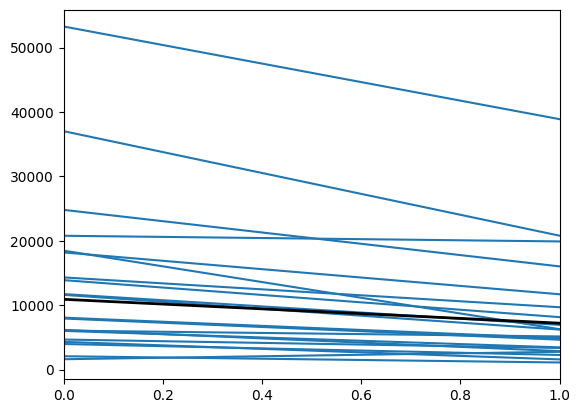

In [8]:
fig, ax = plt.subplots()

average_intercept = np.exp(result.params['Intercept'])
average_slope = np.exp(result.params['year[T.2022]'])

random_effects: pd.DataFrame = pd.DataFrame(np.exp(log_random_effects))
 
for sensor_id, (sensor_effect, year_effect) in random_effects.sample(20).iterrows(): 
    sensor_intercept = sensor_effect * average_intercept
    sensor_slope = average_slope * year_effect

    ax.axline((0, sensor_intercept), (1, sensor_intercept * sensor_slope))

ax.axline(
    (0, average_intercept),
    (1, average_intercept * average_slope),
    color='black',
    linewidth=2,
    label='Average sensor'
)

ax.set_xlim(0, 1)

In [9]:
print(f"Sensors in model but not in locations: {set(result.random_effects.keys()) - set(locations['sensor_id'].unique())}")


Sensors in model but not in locations: {np.int64(57), np.int64(26), np.int64(7)}


We see that there are a few sensors which do not have entries in our locations dataset. This means we cannot recover their locations however they still contain useful information for our regression so we will just stop considering them from here.

In [14]:
location_effects = pd.merge(
    random_effects, locations.drop(columns=['installation_date', 'note', 'status', 'location']), right_on='sensor_id', left_index=True, how='inner'
)
location_effects['total_year_effect'] = location_effects['year_effect'] * average_slope
location_effects['percentage_change'] = round((location_effects['total_year_effect'] - 1) * 100, 3)
location_effects.to_parquet(config.PROCESSED_DATA_DIR / 'location_effects.parquet')

In [15]:
data.to_parquet(config.PROCESSED_DATA_DIR / 'analysis_data.parquet')